In [1]:
import pandas as pd
import numpy as np
import os

def filter_and_undersample(
    resmat: pd.DataFrame, 
    min_threshold: int, 
    output_dir: str = "data"
) -> pd.DataFrame:
    """
    Filters scenarios by a minimum size and then undersamples the rest to be balanced.

    Args:
        resmat (pd.DataFrame): The original, imbalanced response matrix.
        min_threshold (int): The minimum number of items a scenario must have to be included.
        output_dir (str): The directory where the output file will be saved.

    Returns:
        pd.DataFrame: A new DataFrame with filtered and balanced scenarios.
    """
    print("--- Starting Filtering and Undersampling Process ---")
    
    # 1. Get original scenario counts
    scenario_labels = resmat.columns.get_level_values('scenario')
    scenario_counts = scenario_labels.value_counts()
    
    # 2. First, filter out any scenarios that are smaller than the threshold
    scenarios_to_process = scenario_counts[scenario_counts >= min_threshold]
    
    if len(scenarios_to_process) < 2:
        print(f"Warning: Less than two scenarios meet the threshold of {min_threshold}. Cannot create a balanced dataset.")
        return pd.DataFrame()
        
    print(f"Kept {len(scenarios_to_process)} scenarios with at least {min_threshold} items.")
    
    # 3. From the REMAINING scenarios, find the new minimum size to use for sampling
    target_sample_size = scenarios_to_process.min()
    print(f"All kept scenarios will be undersampled to {target_sample_size} items.")

    # 4. Loop through the filtered scenarios and sample them to the new target size
    balanced_cols = []
    np.random.seed(42)  # for reproducibility
    for scenario in scenarios_to_process.index:
        scenario_col_indices = np.where(scenario_labels == scenario)[0]
        sampled_indices = np.random.choice(
            scenario_col_indices, size=target_sample_size, replace=False
        )
        balanced_cols.extend(sampled_indices)

    # 5. Create the new, balanced DataFrame
    resmat_balanced = resmat.iloc[:, sorted(balanced_cols)]
    print(f"New balanced matrix shape: {resmat_balanced.shape}")
    
    # 6. Remove models (rows) that have no responses after undersampling
    responses_per_model = resmat_balanced.notna().sum(axis=1)
    models_with_responses = responses_per_model > 0
    empty_models_count = (~models_with_responses).sum()
    
    if empty_models_count > 0:
        print(f"Warning: {empty_models_count} models have no responses after undersampling.")
        print(f"Removing these empty models to ensure calibration condition is met.")
        resmat_balanced = resmat_balanced[models_with_responses]
        print(f"Final matrix shape after removing empty models: {resmat_balanced.shape}")
    else:
        print("✅ All models have at least one response.")
    
    # Verify calibration condition
    final_rows_check = (resmat_balanced.notna().sum(axis=1) > 0).all()
    final_cols_check = (resmat_balanced.notna().sum(axis=0) > 0).all()
    calibration_valid = final_rows_check and final_cols_check
    print(f"Calibration condition check: {'✅ PASS' if calibration_valid else '❌ FAIL'}")
    
    if not calibration_valid:
        print("Warning: Dataset still fails calibration condition!")

    # 7. Save the new DataFrame to a pickle file
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    output_filename = f"resmat_{min_threshold}.pkl"
    full_path = os.path.join(output_dir, output_filename)
    resmat_balanced.to_pickle(full_path)
    print(f"Saved balanced DataFrame to: '{full_path}'")
    print("--------------------------------------------------")
    
    return resmat_balanced

In [2]:
# --- Step 1: Load Data and Print Original Counts ---
print("Loading response matrix...")
resmat = pd.read_pickle("../data/resmat.pkl")

print("\n--- Original Scenario Counts ---")
scenario_counts = resmat.columns.get_level_values('scenario').value_counts()
print(scenario_counts)
print("--------------------------------")

# --- Step 2: Perform Filtering and Undersampling ---
# Use the new function. For example, require at least 500 items per scenario.
resmat_balanced = filter_and_undersample(resmat, min_threshold=2000, output_dir="../data")

if resmat_balanced.empty:
    raise ValueError("Undersampling resulted in an empty DataFrame. Try a smaller min_threshold.")

# The rest of your script for train/test split, SVD, and evaluation follows...

Loading response matrix...

--- Original Scenario Counts ---
scenario
civil_comments                 29407
mmlu                           13223
wikifact                        5511
air_bench_2024                  4985
imdb                            3530
babi_qa                         3461
boolq                           3316
synthetic_reasoning             2234
legalbench                      1997
truthful_qa                     1888
entity_matching                 1396
raft                            1336
bbq                              999
med_qa                           998
gsm                              997
legal_support                    594
thai_exam                        557
dyck_language_np=3               500
commonsense                      498
lsat_qa                          454
math                             436
entity_data_imputation           395
ice                                0
synthetic_efficiency               0
blimp                              0
twitt

Loading response matrix...
Training set size (80%): 910536
Test set size (20%): 227634

Starting iteration to find the best rank (k)...
  k= 2, Global AUC = 0.8308
  k= 3, Global AUC = 0.8569
  k= 4, Global AUC = 0.8759
  k= 5, Global AUC = 0.8797
  k= 6, Global AUC = 0.8872
  k= 7, Global AUC = 0.8884
  k= 8, Global AUC = 0.8913
  k= 9, Global AUC = 0.8911
  k=10, Global AUC = 0.8882
  k=11, Global AUC = 0.8876
  k=12, Global AUC = 0.8854
  k=13, Global AUC = 0.8830
  k=14, Global AUC = 0.8813
  k=15, Global AUC = 0.8770
  k=16, Global AUC = 0.8724
  k=17, Global AUC = 0.8680
  k=18, Global AUC = 0.8631
  k=19, Global AUC = 0.8589
  k=20, Global AUC = 0.8563
  k=21, Global AUC = 0.8512
  k=22, Global AUC = 0.8478
  k=23, Global AUC = 0.8409
  k=24, Global AUC = 0.8384
  k=25, Global AUC = 0.8313
  k=26, Global AUC = 0.8268
  k=27, Global AUC = 0.8240
  k=28, Global AUC = 0.8180
  k=29, Global AUC = 0.8198
  k=30, Global AUC = 0.8123

Iteration complete.

--- Optimal Rank Results ---
T

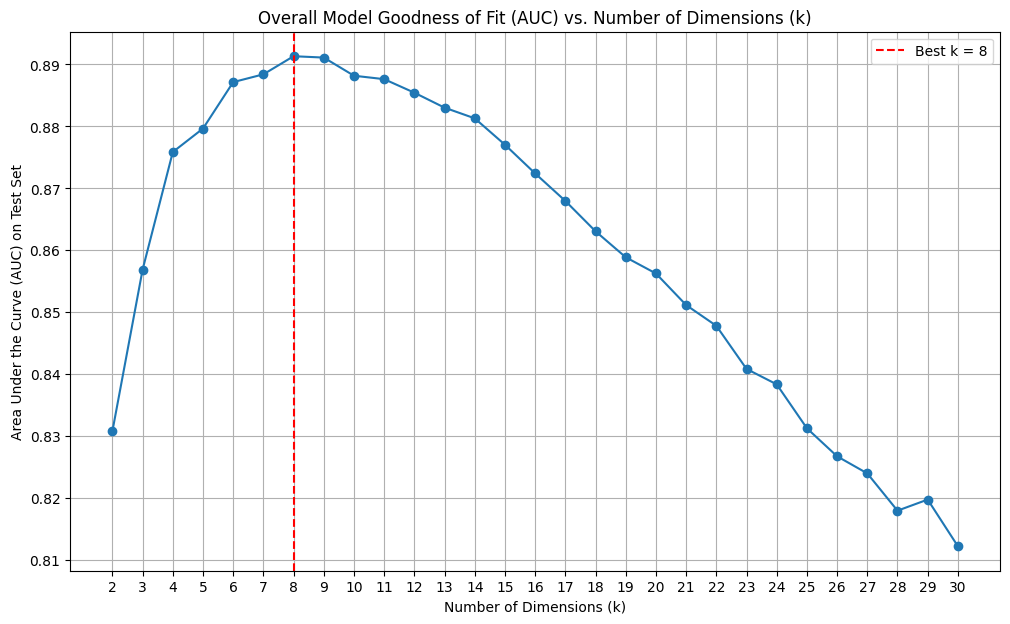


Training final model with optimal k=8 for stratified evaluation...

--- AUC Performance by Scenario ---
              scenario       auc  test_samples
0                 mmlu  0.892254         35405
1       air_bench_2024  0.882993         18200
2             wikifact  0.867131         29939
3                boolq  0.867044         29547
4       civil_comments  0.863077         29939
5  synthetic_reasoning  0.855833         30740
6                 imdb  0.853884         22723
7              babi_qa  0.798757         31141


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ===================================================================
# == Step 1: Load Data and Create a One-Time Train/Test Split
# ===================================================================
print("Loading response matrix...")
# Note: Ensure the path to your data file is correct.
resmat = pd.read_pickle("../data/resmat_2000.pkl")

# Find the locations (row, col indices) of all non-missing values
non_nan_indices = np.argwhere(resmat.notna().values)

# Randomly shuffle these indices
np.random.seed(42)  # for reproducibility
np.random.shuffle(non_nan_indices)

# Decide on the split size
test_size = int(len(non_nan_indices) * 0.20)
test_indices = non_nan_indices[:test_size]
train_indices = non_nan_indices[test_size:]

# Create the training matrix: start with a copy and hide the test data
train_resmat = resmat.copy()
test_rows, test_cols = test_indices[:, 0], test_indices[:, 1]
train_resmat.values[test_rows, test_cols] = np.nan

print(f"Training set size (80%): {len(train_indices)}")
print(f"Test set size (20%): {len(test_indices)}")

# Prepare the data needed for evaluation (do this once)
true_test_values = resmat.values[test_rows, test_cols]
# Using fillna(0) as in your script. Another option is the mean.
imputed_train_resmat = train_resmat.fillna(0)

# ===================================================================
# == Step 2: Iterate Through Dimensions and Calculate Global AUC
# ===================================================================
results = []
rank_range = range(2, 31) # Iterate from k=2 to k=30

print("\nStarting iteration to find the best rank (k)...")
for k in rank_range:
    svd = TruncatedSVD(n_components=k, random_state=42)
    transformed_data = svd.fit_transform(imputed_train_resmat)
    prediction_matrix = svd.inverse_transform(transformed_data)
    predicted_test_values = prediction_matrix[test_rows, test_cols]
    
    # Ensure there are both 0s and 1s in the true values to calculate AUC
    if len(np.unique(true_test_values)) > 1:
        auc_score = roc_auc_score(true_test_values, predicted_test_values)
        results.append({'k': k, 'auc': auc_score})
        print(f"  k={k:2d}, Global AUC = {auc_score:.4f}")

print("\nIteration complete.")

# ===================================================================
# == Step 3: Find and Display the Best Overall Result
# ===================================================================
results_df = pd.DataFrame(results)
best_k_row = results_df.loc[results_df['auc'].idxmax()]
OPTIMAL_K = int(best_k_row['k'])

print("\n--- Optimal Rank Results ---")
print(f"The best performing model has k = {OPTIMAL_K} with a Global AUC of {best_k_row['auc']:.4f}")

# ===================================================================
# == Step 4: Plot the Overall Results
# ===================================================================
plt.figure(figsize=(12, 7))
plt.plot(results_df['k'], results_df['auc'], marker='o', linestyle='-')
plt.axvline(x=OPTIMAL_K, color='r', linestyle='--', label=f'Best k = {OPTIMAL_K}')
plt.title('Overall Model Goodness of Fit (AUC) vs. Number of Dimensions (k)')
plt.xlabel('Number of Dimensions (k)')
plt.ylabel('Area Under the Curve (AUC) on Test Set')
plt.grid(True)
plt.legend()
plt.xticks(rank_range)
plt.show()

# ===================================================================
# == Step 5: Perform Stratified Evaluation with the Best Model
# ===================================================================
print(f"\nTraining final model with optimal k={OPTIMAL_K} for stratified evaluation...")
final_svd = TruncatedSVD(n_components=OPTIMAL_K, random_state=42)
final_svd.fit(imputed_train_resmat)
prediction_matrix_final = final_svd.inverse_transform(final_svd.transform(imputed_train_resmat))

print("\n--- AUC Performance by Scenario ---")
# Get the scenario label for every column in the matrix
scenario_labels = resmat.columns.get_level_values('scenario')
unique_scenarios = scenario_labels.unique()

stratified_results = []

# Loop through each unique scenario
for scenario in unique_scenarios:
    # Find column indices that match the current scenario
    scenario_col_indices = np.where(scenario_labels == scenario)[0]
    
    # Find which test samples belong to this scenario
    is_in_scenario = np.isin(test_indices[:, 1], scenario_col_indices)
    scenario_test_indices = test_indices[is_in_scenario]
    
    if len(scenario_test_indices) < 10: # Skip if too few test samples
        continue

    # Get true and predicted values for this scenario's test set
    s_test_rows, s_test_cols = scenario_test_indices[:, 0], scenario_test_indices[:, 1]
    s_true_values = resmat.values[s_test_rows, s_test_cols]
    s_predicted_values = prediction_matrix_final[s_test_rows, s_test_cols]
    
    # Check if there's more than one class (0s and 1s) to calculate AUC
    if len(np.unique(s_true_values)) > 1:
        auc = roc_auc_score(s_true_values, s_predicted_values)
        stratified_results.append({'scenario': scenario, 'auc': auc, 'test_samples': len(s_true_values)})

# Display the stratified results in a clean DataFrame
stratified_df = pd.DataFrame(stratified_results).sort_values(by='auc', ascending=False).reset_index(drop=True)
print(stratified_df)

# Dimensional Reduction, train on fixed k

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# ===================================================================
# == Step 1: Train the Final SVD Model with Optimal k=11
# ===================================================================
print("Loading and preparing data...")
resmat = pd.read_pickle("../data/resmat_2000.pkl")

imputed_resmat = resmat.fillna(0)

# Train the final SVD model with your chosen rank
OPTIMAL_K = 8
svd_final = TruncatedSVD(n_components=OPTIMAL_K, random_state=42)
svd_final.fit(imputed_resmat)
print(f"Final model trained with k={OPTIMAL_K}.")


Loading and preparing data...
Final model trained with k=8.


In [6]:
ability_scores = svd_final.transform(imputed_resmat)
# 2. Put the scores into a DataFrame for easy interpretation
# Use the original model names from the resmat index.
model_names = resmat.index
factor_names = [f'Ability_Factor_{i+1}' for i in range(ability_scores.shape[1])]

ability_df = pd.DataFrame(ability_scores, index=model_names, columns=factor_names)

# 3. Display the results
print("--- Estimated Model Abilities ---")
print(ability_df.sort_values(by='Ability_Factor_1', ascending=False).head(10))

--- Estimated Model Abilities ---
                            Ability_Factor_1  Ability_Factor_2  \
request.model                                                    
openai/text-davinci-002            83.471841         -5.650430   
meta/llama-2-70b                   82.202713         28.065157   
openai/text-davinci-003            81.489786         -5.391372   
ai21/j1-grande-v2-beta             79.528028         -6.439369   
mistralai/mistral-7b-v0.1          79.451748         21.408032   
meta/llama-65b                     79.321683         -4.886817   
ai21/j2-grande                     79.022022         -6.372870   
openai/gpt-3.5-turbo-0613          78.803248         41.644222   
meta/llama-30b                     77.967752         -5.437420   
cohere/command-xlarge-beta         77.488422         -6.035479   

                            Ability_Factor_3  Ability_Factor_4  \
request.model                                                    
openai/text-davinci-002             1.286

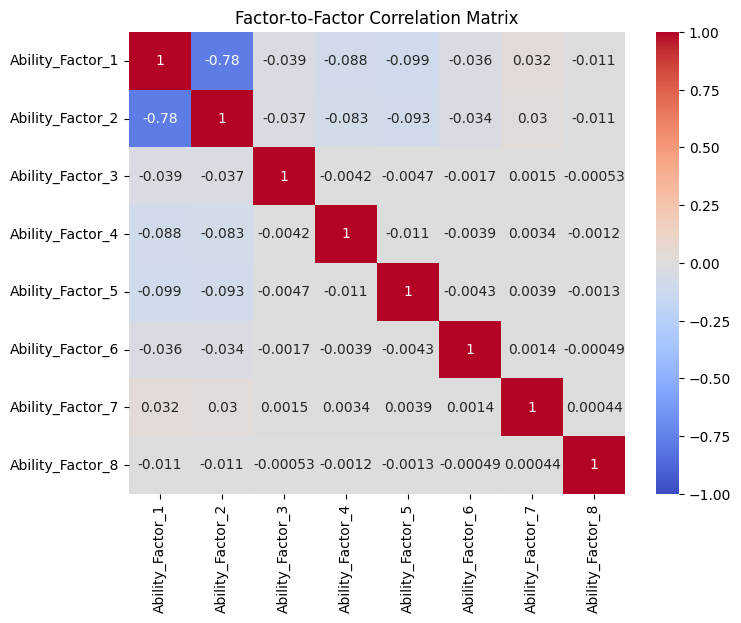

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'ability_df' is your DataFrame of model abilities from the previous step
# It should have a shape of (n_models, k_factors)

# Calculate the correlation between the ability factors
factor_correlations = ability_df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(factor_correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Factor-to-Factor Correlation Matrix')
plt.show()

/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_5872/1833635784.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  scenario_scores = resmat.groupby(level='scenario', axis=1).mean()
/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_5872/1833635784.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scenario_scores = resmat.groupby(level='scenario', axis=1).mean()


Created aggregated scenario scores DataFrame with shape: (183, 40)

Dropped 0 scenarios with zero variance: []
Kept 22 scenarios for correlation analysis.


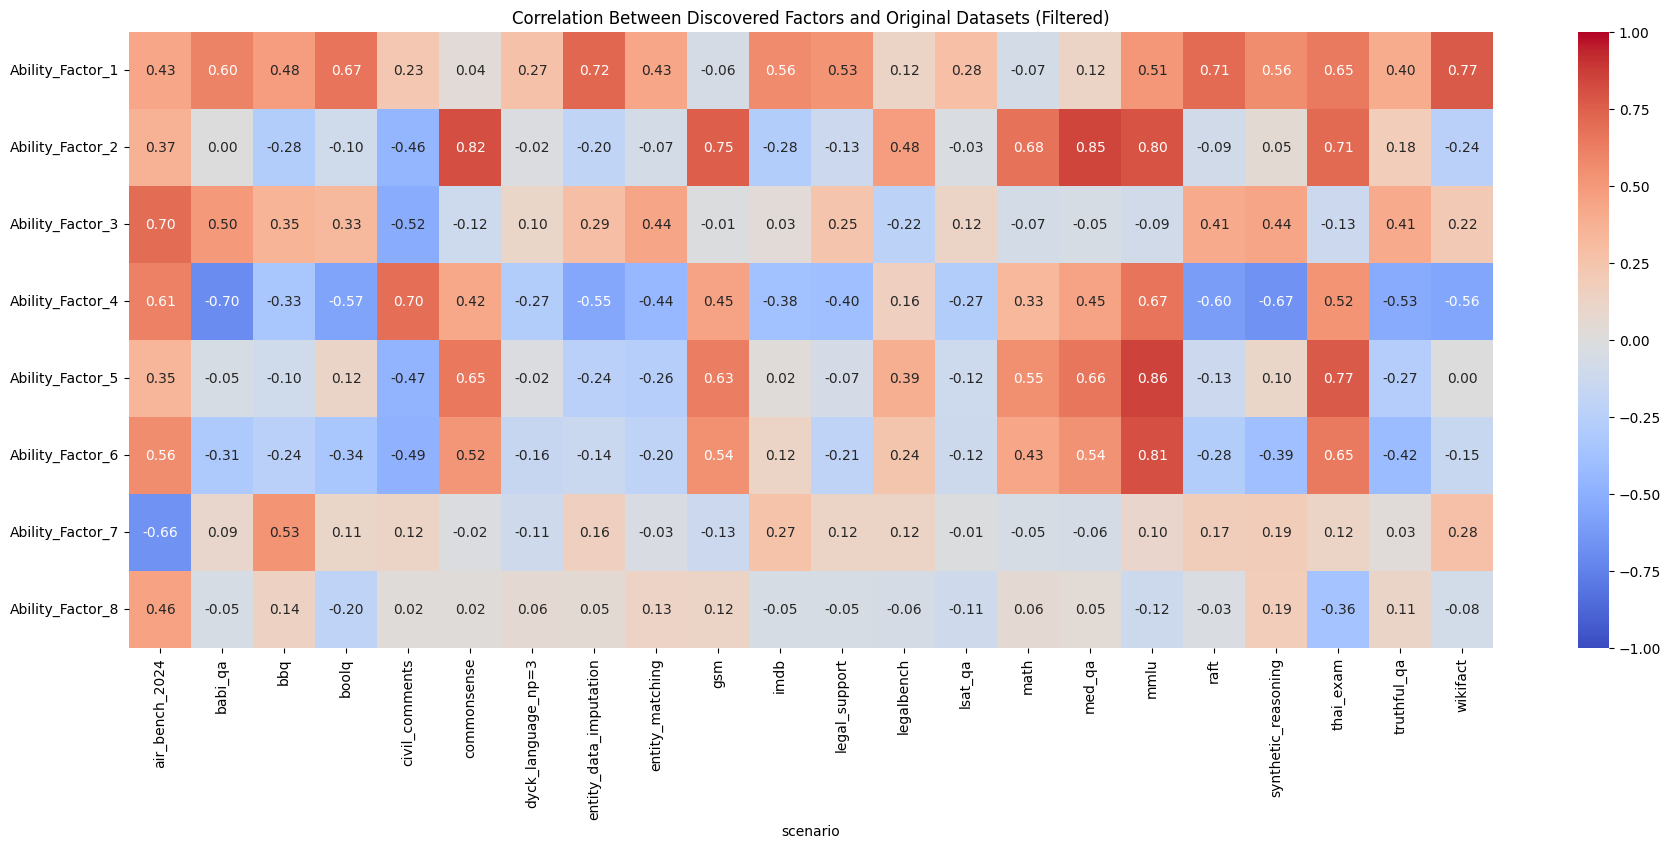

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'ability_df' is your (183, k) DataFrame of model abilities

# --- Step A: Aggregate resmat to get per-scenario scores ---
resmat = pd.read_pickle("../data/resmat.pkl")
scenario_scores = resmat.groupby(level='scenario', axis=1).mean()
print(f"Created aggregated scenario scores DataFrame with shape: {scenario_scores.shape}")

# --- NEW: Step B: Identify and filter out zero-variance scenarios ---
# Calculate the standard deviation of each scenario's scores
std_devs = scenario_scores.std()

# Find the scenarios where the scores actually vary (std > 0)
scenarios_to_keep = std_devs[std_devs > 0].index
scenarios_dropped = std_devs[std_devs == 0].index

# Create a new DataFrame with only the valid scenarios
scenario_scores_filtered = scenario_scores[scenarios_to_keep]

print(f"\nDropped {len(scenarios_dropped)} scenarios with zero variance: {list(scenarios_dropped)}")
print(f"Kept {len(scenarios_to_keep)} scenarios for correlation analysis.")


# --- Step C: Combine ability scores and the FILTERED scenario scores ---
combined_df = pd.concat([ability_df, scenario_scores_filtered], axis=1)


# --- Step D: Calculate the full correlation matrix ---
full_correlations = combined_df.corr(method='spearman')


# --- Step E: Isolate and visualize the part we care about ---
# We now use the filtered list of columns
factor_scenario_corr = full_correlations.loc[ability_df.columns, scenario_scores_filtered.columns]

plt.figure(figsize=(22, 8))
sns.heatmap(factor_scenario_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Spearman correlation Between Discovered Factors and Original Datasets (Filtered)')
plt.show()

In [20]:
# ===================================================================
# == Step 2: Extract the Scenario Representations
# ===================================================================
# The matrix `svd_final.components_` has a shape of (k, n_scenarios).
# We need to transpose it to get (n_scenarios, k) for t-SNE.
scenario_factors = svd_final.components_.T
print(f"Extracted scenario factors with shape: {scenario_factors.shape}")

# ===================================================================
# == Step 3: Run t-SNE to Reduce to 2 Dimensions
# ===================================================================
print("\nRunning t-SNE to reduce dimensions for visualization...")
# Note: t-SNE can be slow on large datasets. This might take a few minutes.
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
scenario_2d = tsne.fit_transform(scenario_factors)
print(f"t-SNE complete. New data shape: {scenario_2d.shape}")

Extracted scenario factors with shape: (17872, 8)

Running t-SNE to reduce dimensions for visualization...
t-SNE complete. New data shape: (17872, 2)


In [21]:
np.save("../result/scenario_2d.npy", scenario_2d)
np.save("../result/scenario_factors.npy", scenario_factors)

/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_5872/1261388769.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(unique_scenarios))



Generating plot...


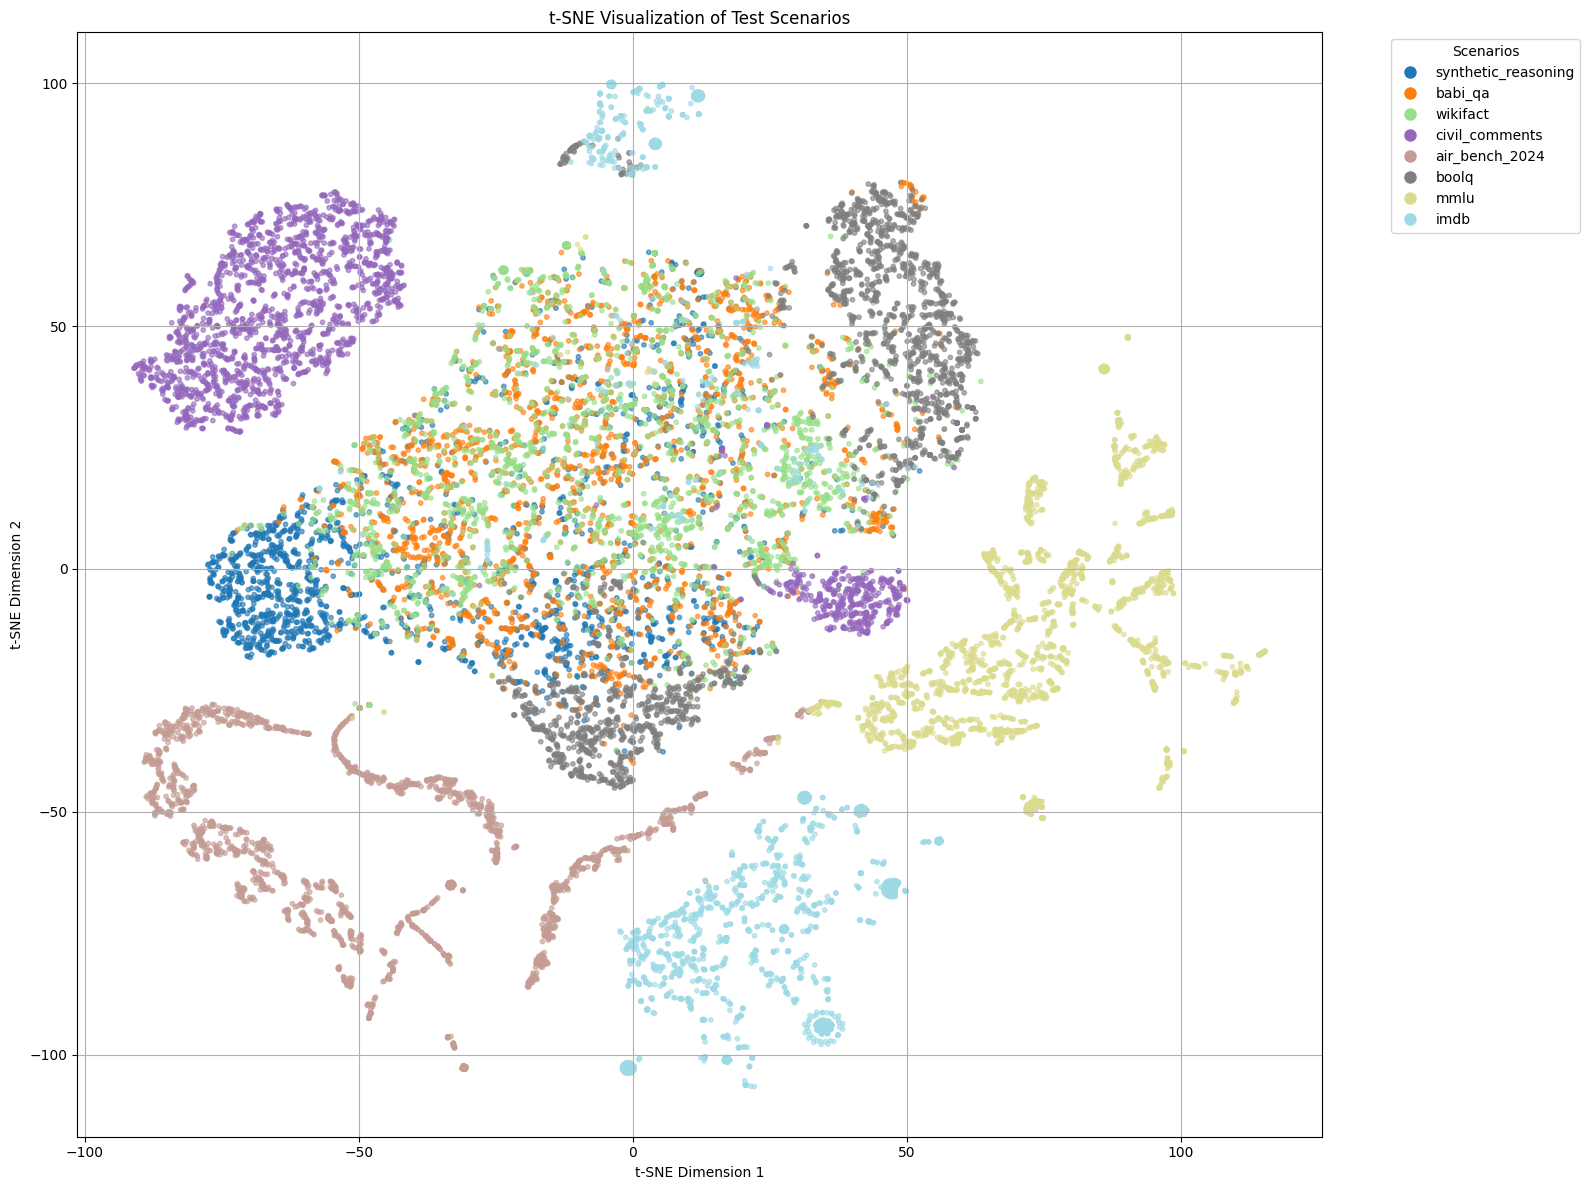

In [22]:
# ===================================================================
# == Step 4: Create an Interpretable Visualization
# ===================================================================
# To color the plot, we need to know which scenario each of the 78,712 columns belongs to.
# Let's load the scenario names and the mapping you created in your notebook.

# Load the list of unique scenario names (there should be 22)
balanced_resmat = pd.read_pickle("../data/resmat_2000.pkl").columns.to_frame()
unique_scenarios = balanced_resmat['scenario'].unique().tolist()

# Get the scenario label for each of the 78,712 columns
scenario_labels = balanced_resmat['scenario'].values

# Create a color map for the unique scenarios
colors = cm.get_cmap('tab20', len(unique_scenarios))
color_map = {scenario: colors(i) for i, scenario in enumerate(unique_scenarios)}
point_colors = [color_map[label] for label in scenario_labels]

print("\nGenerating plot...")
plt.figure(figsize=(16, 12))
scatter = plt.scatter(scenario_2d[:, 0], scenario_2d[:, 1], c=point_colors, alpha=0.6, s=10)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=scen,
                      markerfacecolor=color_map[scen], markersize=10) for scen in unique_scenarios]
plt.legend(handles=handles, title='Scenarios', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('t-SNE Visualization of Test Scenarios')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.tight_layout()
plt.show()